## 0: Section Overview

In the following documentation, we will explore the use of auto-encoders to address the question: Can we predict artist preferences for users based off left-out test data? We want to evaluate the computational performance of this model, while applying it to make predictions based off user data on artist preferences. Thus we will also address the question: How can different approaches to a recommender system affect the computational performance of our models?

## 1: Necessary Imports

In [79]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

## 2: Data Access and Preparation

Our data is available in our GitHub repository in the file 'Data'.

In [6]:
path1 = '../data/user_artists.dat'
path2 = '../data/artists.dat'

user_data = pd.read_csv(path1, sep='\t')
artist_ids = pd.read_csv(path2, sep='\t')

We will now split the data into a test and train set so that we can evaluate our model on unseen data. We will then split the test set further into `test_x` and `test_y` such that we can use `test_x` to generate a prediction using our model, and `test_y` to evaluate this prediction. The train and test set will be split so that they contain mutually exclusive users, and 80% of the data is used for the train set and 20% for the test set. The test set will then be split so that 50% of each user's data is in `test_x` and `test_y`. This makes sense in the context of the problem since I want to ensure that the model has enough input data to provide a good prediction, but also enough verification data to accurately measure its performance. For this model, performance can be considered 'good' if many of its recommendations from `test_x` can also be observed in `test_y`, however there is a certain amount of randomness in this approach. Potentially the model could be providing 'good' predictions, but by chance, these do not correspond to the user's preferences in `test_y`. This is why we dedicate more data than is standard practice to the `test_y` set, to give a greater chance of the model's 'good' performance being recognised.

In [13]:
user_interaction_counts = user_data.groupby('userID').size()
users_with_50_interactions = user_interaction_counts[user_interaction_counts >= 50].index
user_data_filtered = user_data[user_data['userID'].isin(users_with_50_interactions)]

unique_users = user_data_filtered['userID'].unique()

# Ensure that test users have at least 50 interactions in 'test_data'

np.random.seed(42)

shuffled_users = np.random.permutation(unique_users)

train_users = []
test_users = []

# Collect test users until we have enough that have at least 50 interactions
for user in shuffled_users:
    user_data_temp = user_data_filtered[user_data_filtered['userID'] == user]
    if len(test_users) < int(0.2 * len(unique_users)):
        test_users.append(user)
    else:
        train_users.append(user)

# Recreate test_data and train_data
train_data = user_data_filtered[user_data_filtered['userID'].isin(train_users)]
test_data = user_data_filtered[user_data_filtered['userID'].isin(test_users)]

# Now check that each user in test_data has 50 interactions
# Remove any users from test_users who don't meet this criterion
valid_test_users = []
for user in test_users:
    user_data_temp = test_data[test_data['userID'] == user]
    if len(user_data_temp) == 50:
        valid_test_users.append(user)

# Update test_users and test_data
test_users = valid_test_users
test_data = test_data[test_data['userID'].isin(test_users)]

# Update train_data to include any users removed from test_users
removed_test_users = set(shuffled_users) - set(train_users) - set(test_users)
if removed_test_users:
    train_users.extend(list(removed_test_users))
    train_data = user_data_filtered[user_data_filtered['userID'].isin(train_users)]

# Split test_data into test_x and test_y
test_x = pd.DataFrame(columns=test_data.columns)
test_y = pd.DataFrame(columns=test_data.columns)

for user in test_users:
    user_data_temp = test_data[test_data['userID'] == user]
    user_data_shuffled = user_data_temp.sample(frac=1, random_state=42)
    user_test_x = user_data_shuffled.iloc[:25]
    user_test_y = user_data_shuffled.iloc[25:50]
    test_x = pd.concat([test_x, user_test_x], ignore_index=True)
    test_y = pd.concat([test_y, user_test_y], ignore_index=True)

Next we will encode our data using `LabelEncoder()` which converts categorical variables into numerical representations. Although our values are already numerical in this case, using an encoder can still be useful for ensuring the indices are compact and suitable for tensor or matrix operations, and also as a method for decoding indices back to original IDs for interpretability.

In [14]:
# Encode artistIDs
artist_encoder = LabelEncoder()
all_artistIDs = user_data_filtered['artistID'].unique()
artist_encoder.fit(all_artistIDs)
num_artists = len(artist_encoder.classes_)

# Encode train users
train_user_encoder = LabelEncoder()
train_user_encoder.fit(train_users)
num_train_users = len(train_user_encoder.classes_)

# Encode test users
test_user_encoder = LabelEncoder()
test_user_encoder.fit(test_users)
num_test_users = len(test_user_encoder.classes_)

Now, we will create a user-item interaction matrix, and will scale our data before inputting it into the autoencoder. A user-interaction matrix is a structured and computationally efficient way to represent user preferences since its structure allows VAEs to leverage GPU acceleration for faster training, which we will see later. Data normalisation is essential for improving training efficiency, and preventing instability. If the data has a wide range of values, the model's weights may not converge during training, whearas for normalised data, the optimisation process becomes more stable and faster.

In [15]:
# Function to create user-item interaction matrix
def create_user_item_matrix(data, user_encoder, num_users):
    user_item_matrix = np.zeros((num_users, num_artists))
    for idx, row in data.iterrows():
        user_idx = user_encoder.transform([row['userID']])[0]
        artist_idx = artist_encoder.transform([row['artistID']])[0]
        weight = row['weight']
        user_item_matrix[user_idx, artist_idx] = weight
    return user_item_matrix

train_user_item_matrix = create_user_item_matrix(train_data, train_user_encoder, num_train_users)
test_x_user_item_matrix = create_user_item_matrix(test_x, test_user_encoder, num_test_users)
test_y_user_item_matrix = create_user_item_matrix(test_y, test_user_encoder, num_test_users)

# Scale data before inputting it into autoencoder
# Find the maximum and minimum values across all matrices for consistent scaling
max_value = max(train_user_item_matrix.max(), test_x_user_item_matrix.max(), test_y_user_item_matrix.max())
min_value = min(train_user_item_matrix.min(), test_x_user_item_matrix.min(), test_y_user_item_matrix.min())

# Define a function to normalise a matrix
def normalise(matrix, min_value, max_value):
    return (matrix - min_value) / (max_value - min_value)

# Normalise each matrix
train_user_item_matrix = normalise(train_user_item_matrix, min_value, max_value)
test_x_user_item_matrix = normalise(test_x_user_item_matrix, min_value, max_value)
test_y_user_item_matrix = normalise(test_y_user_item_matrix, min_value, max_value)

## 3: Variational Autoencoders

### 3.1: Model Definition

We will now define the autoencoder using object oriented programming. In the context of our problem, variational autoencoders (VAEs) will be useful since they provide a probabilistic approach to autoencoders. Unlike standard autoencoders, VAEs model the latent space as a continuous, smooth distribution with the learned parameters of mean and (log-)variance. Thus VAEs are generative as the model output is reconstructed from the latent space by sampling from the learned distribution. This generative property makes VAEs particularly appropriate for creating Recommender Systems since they address the cold-start problem, and problems associated data sparcity, by generating recommendations for unseen users effectively using the latent space distribution. Our VAE model consists of the functions: `__init__` , `encode`, `rreparametrise`, `decode`, and `forward`. The `__init__` function intialised the parameters of the input dimension, hidden dimension and latent dimension. The `encode` function respectively encodes to the latent space by outputting the mean and log-variance. `reparametrise` allows backprapogation by inputting the mean and log-variance and outputting a latent sample from $\mathcal{N}(\mu, \sigma^2)$, whilst also sampling noise from a standard normal distribution. Then the function `decode` decodes the latent variable z back to the original data space, and `forward` in the function that defines the forward pass of the VAE by combining the other functions.

In [65]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar
    
    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc_decode(z))
        return torch.sigmoid(self.fc_out(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        return self.decode(z), mu, logvar

### 3.2: Model Training

Now we will train our model using the `train_user_item_matrix` created from our train dataset. We use a dataloader to implement batches which splits the data into smaller batches, so that only a smaller subset of the data is loaded into memory at any time, making the model more computationally efficient. Moreover, if a GPU is available, it can leverage the parallel computation capabilities of batches for efficient data processing, which speeds up training.

For readability, and to facilitate adapting the model later, we will use a series of functions to define the implementation of our model.

In [73]:
def train_model(train_user_item_matrix, artist_encoder, layers):
    # Convert train data to tensor
    train_tensor = torch.FloatTensor(train_user_item_matrix)

    # Create DataLoader
    batch_size = 64
    train_dataset = torch.utils.data.TensorDataset(train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialise the model, optimiser, and loss function
    num_artists = len(artist_encoder.classes_)

    if layers == 1:
        input_dim = num_artists
        hidden_dim = 256
        latent_dim = 50
        model = VAE(input_dim, hidden_dim, latent_dim)

    if layers == 2:
        input_dim = num_artists
        hidden_dim1 = 512
        hidden_dim2 = 256
        latent_dim = 50
        model = VAE(input_dim, hidden_dim1, hidden_dim2, latent_dim)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    def loss_function(recon_x, x, mu, logvar):
        MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data_batch in train_loader:
            data = data_batch[0]
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        # We have the option to print the loss at each epoch
        loss_at_epoch = train_loss / len(train_loader.dataset)

    model.eval()
    latent_mu_list = []
    latent_logvar_list = []

    with torch.no_grad():
        for data_batch in train_loader:  # or test_loader
            data = data_batch[0]
            mu, logvar = model.encode(data)
            latent_mu_list.append(mu)
            latent_logvar_list.append(logvar)

    latent_mu = torch.cat(latent_mu_list).cpu().numpy()

    return model, latent_mu

### 3.3: Model Testing

Now we will test our model using our test data. We will provide a variety of metrics which can each be used to judge model performance. MSE is the standard metric which measures the squared difference between the values of the reconstructed output, `predictions`, and the true values, `test_y_tensor`. The hit rate @ k measures the proportion of users for which at least one of their top-k predictions (the top-k elements of `predictions`), is also in `test_y_tensor`. The Normalised Discounted Cumulative Gain (NDCG) measures how well the model ranks relevant items along the top-k predictions, while taking into account the ranking of recommendations.

In [67]:
def test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric, k=5):

    # Convert test data to tensor
    test_x_tensor = torch.FloatTensor(test_x_user_item_matrix)
    test_y_tensor = torch.FloatTensor(test_y_user_item_matrix)

    # Get the model's predictions on test_x
    model.eval()

    with torch.no_grad():
        predictions, _, _ = model(test_x_tensor) # Reconstructed predictions

    if metric == 'MSE':
        mse_loss = nn.functional.mse_loss(predictions, test_y_tensor)
        return mse_loss

    if metric == 'Hit Rate':
        def hit_rate_at_k(true_matrix, predicted_matrix, k):
            hits = 0
            n_users = true_matrix.shape[0]

            for user_idx in range(n_users):

                _, top_k_indices = torch.topk(predicted_matrix[user_idx], k=k, largest=True, sorted=True)

                if torch.any(true_matrix[user_idx][top_k_indices] > 0):
                    hits += 1

            return hits / n_users
        
        hit_rate = hit_rate_at_k(test_y_tensor, predictions, k)
        return hit_rate
    
    if metric == 'NDCG':
        def ndcg_at_k(true_matrix, predicted_matrix, k):
            n_users = true_matrix.shape[0]
            ndcg_scores = torch.zeros(n_users)

            for user_idx in range(n_users):
                _, top_k_indices = torch.topk(predicted_matrix[user_idx], k=k, largest=True, sorted=True)
                
                true_relevance = true_matrix[user_idx][top_k_indices]

                # Compute DCG@k
                gains = true_relevance / torch.log2(torch.arange(2, k + 2, dtype=torch.float32))
                dcg = torch.sum(gains)

                # Compute IDCG@k (ideal DCG)
                sorted_relevance, _ = torch.sort(true_matrix[user_idx], descending=True)
                ideal_relevance = sorted_relevance[:k]
                ideal_gains = ideal_relevance / torch.log2(torch.arange(2, k + 2, dtype=torch.float32))
                idcg = torch.sum(ideal_gains)

                # Avoid division by zero in case of no relevant items
                ndcg_scores[user_idx] = dcg / idcg if idcg > 0 else 0

            return torch.mean(ndcg_scores)
                
        return ndcg_at_k(test_y_tensor, predictions, k)

In [68]:
model, latent_mu = train_model(train_user_item_matrix, artist_encoder, layers=1)
mse = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='MSE')
print(f"Test MSE: {mse}")
hit_rate = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='Hit Rate')
print(f'Hit Rate: {hit_rate}')
ndcg = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='NDCG')
print(f'NDCG: {ndcg}')

Test MSE: 0.0001239389821421355
Hit Rate: 0.01643835616438356
NDCG: 0.00018262148660141975


### 3.4: Model Visualisation

The above results show ... Now we will plot the latent space in order to visualise how our VAE is .... Since our data points are the rows of our input user-artist interaction matrix (`test_x_user_item_matrix`), we can define `labels` as our user IDs, and use these labels to colour-code the data points in our latent space. 

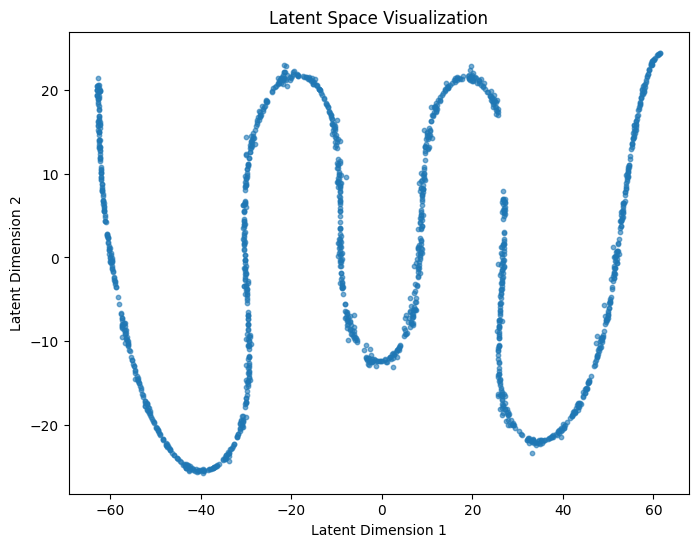

In [69]:
tsne = TSNE(n_components=2, random_state=42)
reduced_latent = tsne.fit_transform(latent_mu)
m = len(test_x_user_item_matrix[0])
list(np.arange(m))
plt.figure(figsize=(8, 6))
plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], alpha=0.6, s=10)
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

We will also display an array of the artists recommended by our model in order to visualise how this compares with the input array.

### 3.5: Baseline Computational Efficiency

In order to evaluate computational efficiency, we will measure the efficiency of the initial version of the model, which will then serve as a baseline. Firstly, we will use the module `time`, which will allow us to track the run time of `train_model` and `test_model`.

In [71]:
start_time = time.time()
model, latent_mu = train_model(train_user_item_matrix, artist_encoder, layers=1)
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

start_time = time.time()
mse = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='MSE')
train_time = time.time() - start_time
print(f"Testing time (with MSE): {train_time:.2f} seconds")

Training time: 24.05 seconds
Testing time (with MSE): 0.10 seconds


## 4: Optimising the Model

### 4.1: Adding Layers

Now, we will adjust our model to try to improve its computational efficiency and its performance. The first adaptation we will make is to add additional layers to the VAE. This has the potential to enable our VAE to capture more complex patterns in the data, resulting in an improved reconstruction accuracy. However there is also a risk of overfitting, and vanishing or exploding gradients.

In [76]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)
        # Decoder
        self.fc_decode1 = nn.Linear(latent_dim, hidden_dim2)
        self.fc_decode2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc_out = nn.Linear(hidden_dim1, input_dim)
        
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar
    
    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Adds noise by sampling from standard normal dist.
        return mu + eps * std
    
    def decode(self, z):
        h2 = torch.relu(self.fc_decode1(z))
        h1 = torch.relu(self.fc_decode2(h2))
        return torch.sigmoid(self.fc_out(h1))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        return self.decode(z), mu, logvar

start_time = time.time()
model, latent_mu = train_model(train_user_item_matrix, artist_encoder, layers=2)
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")
mse = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='MSE')
print(f"Test MSE: {mse}")
hit_rate = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='Hit Rate')
print(f'Hit Rate for k=5: {hit_rate}')
ndcg = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='NDCG')
print(f'NDCG for k=5: {ndcg}')

Training time: 82.73 seconds
Test MSE: 9.205897555375486e-08
Hit Rate for k=5: 0.010958904109589041
NDCG for k=5: 0.0003727848525159061


Note that, while a lower MSE indicates better model performance, a higher hit rate means that the model is 'hitting' more values which indicates better model performance, and similarly for NDCG. Compare and analyse these results ........................................................................................................ also mention how results can vary due to probabilistic nature of VAE.

The hit rate and the NDCG depend on the value of k, with the hit rate becoming stricter for smaller values of k, and the NDCG becoming more sensitive for smaller values of k. In the context of our recommendation system, the hit rate with a large k value may be more appropriate since we want to evaluate the overall recommendation quality of our model, not just the top few recommendations. Additionally, the NDCG may be less relevant since we care less about the ranking of relevant items, because we mostly just want to show that our recommender system can generate appropriate recommendations. However, we must be careful to not choose our k value to be too high, as this can lead to an overly leniant metric which can overestimate the performance of our model.

In [78]:
hit_rate = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='Hit Rate', k=10)
print(f'Hit Rate for k=10: {hit_rate}')
ndcg = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='NDCG', k=10)
print(f'NDCG for k=10: {ndcg}')
hit_rate = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='Hit Rate', k=20)
print(f'Hit Rate for k=20: {hit_rate}')
ndcg = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='NDCG', k=20)
print(f'NDCG for k=20: {ndcg}')

Hit Rate for k=10: 0.00821917808219178
NDCG for k=10: 0.0005691638798452914
Hit Rate for k=20: 0.021917808219178082
NDCG for k=20: 0.0008486972074024379


### 4.2: Changing the Activation Function

We will first consider the Exponential Linear Unit (ELU) activation function. ELU differs from the Rectified Linear Unit (ReLU) in its handling of negative input values. The ReLU function outputs ${x}$ if ${x>0}$, and ${0}$ if $x \leq 0$. This introduces non-linearity to the VAE, allowing it to learn more complex interactions, however it can lead to the 'dying ReLU problem', where an output is consistently negative and thus this layer of the network effectively 'dies', or stops working. This problem can be solved by using ELU, since the ELU allows a small gradient for negative inputs, and also introduces a smooth transition at ${x = 0}$. ELU has the potential to be particularly useful for a VAE model, where the latent space and reconstructed outputs can include a mix of values. However, the ELU function can increase computational cost slightly as it includes an exponential.

In [85]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)
        # Decoder
        self.fc_decode1 = nn.Linear(latent_dim, hidden_dim2)
        self.fc_decode2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc_out = nn.Linear(hidden_dim1, input_dim)

    def encode(self, x):
        h1 = F.elu(self.fc1(x), alpha=1.0)
        h2 = F.elu(self.fc2(h1), alpha=1.0)
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.elu(self.fc_decode1(z), alpha=1.0)
        h1 = F.elu(self.fc_decode2(h2), alpha=1.0)
        return torch.sigmoid(self.fc_out(h1))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        return self.decode(z), mu, logvar

start_time = time.time()
model, latent_mu = train_model(train_user_item_matrix, artist_encoder, layers=2)
train_time = time.time() - start_time
print(f"Training time for ELU: {train_time:.2f} seconds")
mse = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='MSE')
print(f"Test MSE for ELU: {mse}")
hit_rate = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='Hit Rate', k=20)
print(f'Hit Rate for k=20, ELU: {hit_rate}')
ndcg = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='NDCG', k=20)
print(f'NDCG for k=20, ELU: {ndcg}')

Training time for ELU: 77.73 seconds
Test MSE for ELU: 3.4184664400527254e-05
Hit Rate for k=20, ELU: 0.019178082191780823
NDCG for k=20, ELU: 0.0007448518299497664


As we can see, the ELU function seems to perform worst, with the longest training time, which could be due to its greater computational complexity.

We will now try implementing the activation function Leaky Rectified Linear Unit (Leaky ReLU), which also allows small negative values, but does not include an exponential.

In [84]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)
        # Decoder
        self.fc_decode1 = nn.Linear(latent_dim, hidden_dim2)
        self.fc_decode2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc_out = nn.Linear(hidden_dim1, input_dim)

    def encode(self, x):
        h1 = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        h2 = F.leaky_relu(self.fc2(h1), negative_slope=0.01)
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.leaky_relu(self.fc_decode1(z), negative_slope=0.01)
        h1 = F.leaky_relu(self.fc_decode2(h2), negative_slope=0.01)
        return torch.sigmoid(self.fc_out(h1))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        return self.decode(z), mu, logvar

start_time = time.time()
model, latent_mu = train_model(train_user_item_matrix, artist_encoder, layers=2)
train_time = time.time() - start_time
print(f"Training time for Leaky ReLU: {train_time:.2f} seconds")
mse = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='MSE')
print(f"Test MSE for Leaky ReLU: {mse}")
hit_rate = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='Hit Rate',)
print(f'Hit Rate for k=20, Leaky ReLU: {hit_rate}')
ndcg = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='NDCG', k=20)
print(f'NDCG for k=20, Leaky ReLU: {ndcg}')

Training time for Leaky ReLU: 80.76 seconds
Test MSE for Leaky ReLU: 9.422804936320972e-08
Hit Rate for k=20, Leaky ReLU: 0.005479452054794521
NDCG for k=20, Leaky ReLU: 0.0007302876911126077


Now, we will consider batch optimisation for improving our model's performance and compuational efficiency.

### 4.3: Batch optimisation

In autoencoders, batches are subsets of the dataset which can be used to compute the model's forward and backward pass during training. Using batches reduces the computational cost, by dividing the dataset into smaller subsets which are passed through the model one at a time, instead of passing the entire dataset at once. Using a GPU can also parallelise this process which will then be even more computationally efficient, and faster. But choosing the optimal batch size is important, as a smaller batch size can provide greater stochasticity in gradient updates, leading to better model generalisation, while a larger batch size can lead to faster convergence. Batches are especially important when working with large datasets, because they improve efficiency, and allow the model to be trained on data that is too large to fit in memory. We can also adjust our model to include batch normalisation. This can enhance compuational efficiency by normalising the inputs at each layer of the model which can improve convergence.